# VQ-VAE test

In [ ]:
%load_ext autoreload
%autoreload 2

### Helper functions

In [2]:
%matplotlib inline
import matplotlib.pyplot as plt
import torch
import genus as gn
import numpy
from genus.util_data import  DataloaderWithLoad, DatasetInMemory
from genus.util import load_yaml_as_dict, load_obj, save_obj, append_to_dict
from genus.util_vis import show_batch
from genus.model import instantiate_optimizer
import torchvision
from torchvision import transforms
from typing import NamedTuple, Optional
from torch.nn import functional as F
from genus.util_ml import Quantizer, MetricsAccumulator
from genus.conv import EncoderConv, DecoderConv
        
class Metrics(NamedTuple):
    loss: torch.Tensor
    rec: float
    commitment: float
        
    def pretty_print(self, epoch: int = 0) -> str:
        s = "[epoch {0:4d}] loss={1:.3f}, rec={2:.3f}, commitment={3:.3f}".format(epoch,
                                                                                  self.loss,
                                                                                  self.rec,
                                                                                  self.commitment)
        return s

    
def process_one_epoch(model: torch.nn.Module,
                      dataloader: DataloaderWithLoad,
                      optimizer: torch.optim.Optimizer,
                      verbose: bool):

    metric_accumulator = MetricsAccumulator()  # initialize an empty accumulator


    # Anomaly detection is slow but help with debugging
    with torch.autograd.set_detect_anomaly(mode=False):

        # Start loop over minibatches
        for i, (imgs, labels, index) in enumerate(dataloader):

            # Put data in GPU if available
            imgs = imgs.cuda() if (torch.cuda.is_available() and (imgs.device == torch.device('cpu'))) else imgs

            # model.forward returns metric and other stuff
            metrics, _ = model.forward(imgs_in=imgs)

            # Only if training I apply backward
            if model.training:
                optimizer.zero_grad()
                metrics.loss.backward()  # do back_prop and compute all the gradients
                optimizer.step()  # update the parameters

            if verbose:
                print("i = %3d train_loss=%.5f" % (i, metrics.loss.item()))

            # Accumulate metrics over an epoch
            with torch.no_grad():
                metric_accumulator.accumulate(source=metrics, counter_increment=len(index))

    # Make a namedtuple out of the OrderDictionary.
    # Since OrderDictionary preserves the order this preserved order of term.
    return Metrics._make(metric_accumulator.get_average().values())  # robust way to convert dict to namedtuple


class VQVAE(torch.nn.Module):
    def __init__(self, ch_img: int, num_embeddings: int, embedding_dim: int, scale_factor: int) -> None:
        super().__init__()
        self.embedding_dim = embedding_dim
        self.num_embeddings = num_embeddings
        self.encoder = EncoderConv(ch_in=ch_img, ch_out=embedding_dim, scale_factor=scale_factor)
        self.decoder = DecoderConv(ch_in=embedding_dim, ch_out=ch_img, scale_factor=scale_factor)
        self.quantizer = Quantizer(num_embeddings=num_embeddings, embedding_dim=embedding_dim)
        
        if torch.cuda.is_available():
            self.cuda()
    
    
    def forward(self, imgs_in):
        
        x_in = F.pad(imgs_in, pad=[2,2,2,2], mode='constant', value=0)
        assert torch.Size([32,32]) == x_in.shape[-2:]
        z = self.encoder(x_in)
        vq = self.quantizer(z, axis_to_quantize=-3, generate_synthetic_data=False)
        x_out = self.decoder(vq.value)
        
        rec = ((x_out-x_in)/0.1).pow(2).mean()
        loss = rec + vq.commitment_cost
        
        imgs_out = x_out[...,2:-2,2:-2]
        
        rec = ((x_out-x_in)/0.1).pow(2).mean()
        loss = 0.01 * rec + vq.commitment_cost
        
        return Metrics(loss=loss, rec=rec.detach().item(), commitment=vq.commitment_cost.detach().item()), imgs_out

### Create the dataset

In [3]:
# We transform them to tensors
transform = transforms.ToTensor()

train_data = torchvision.datasets.FashionMNIST('./data', train=True, download=True, transform=transform)
test_data = torchvision.datasets.FashionMNIST('./data', train=False, download=True, transform=transform)

# Load and transform data
#train_data = torchvision.datasets.MNIST('./data', train=True, download=True, transform=transform)
#test_data = torchvision.datasets.MNIST('./data', train=False, download=True, transform=transform)


train_dataset = DatasetInMemory(x=train_data.data.unsqueeze(-3).float()/(255.0),
                                y=train_data.targets,
                                store_in_cuda=False)
test_dataset = DatasetInMemory(x=test_data.data.unsqueeze(-3).float()/(255.0),
                               y=test_data.targets,
                               store_in_cuda=False)

BATCH_SIZE = 256
test_loader = DataloaderWithLoad(test_dataset, batch_size=BATCH_SIZE, shuffle=False)
train_loader = DataloaderWithLoad(train_dataset, batch_size=BATCH_SIZE, shuffle=True)

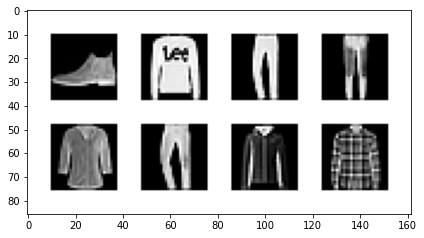

In [4]:
reference_img, _, _ = test_loader.load(index=torch.tensor([0,1,2,3,4,5,6,7]))
if torch.cuda.is_available():
    reference_img = reference_img.cuda()
show_batch(reference_img)


### Test

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


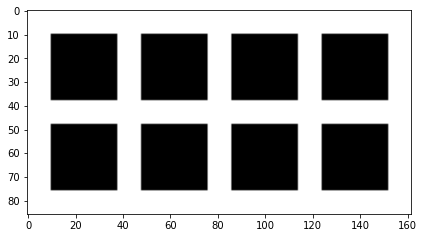

In [5]:
vae = VQVAE(ch_img=1, num_embeddings=10, embedding_dim=32, scale_factor=8)

metrics, reference_img_out = vae(reference_img)
show_batch(reference_img_out)

### Instantiate the model

In [ ]:
TEST_FREQUENCY = 5
NUM_EPOCHS = 150

# for num_embeddings in [10,20,50,100,150,200]:
for embedding_dim in [64,128]:
    history_dict = {}
    vae = VQVAE(ch_img=1, num_embeddings=100, embedding_dim=embedding_dim, scale_factor=8)
    optimizer = instantiate_optimizer(model=vae, 
                                      config_optimizer={'type': "adam", 'lr': 0.001, 'betas_adam': [0.9, 0.999]})

    for epoch in range(1,NUM_EPOCHS+1):
    
        vae.train()
        train_metrics = process_one_epoch(model=vae,
                                          dataloader=train_loader,
                                          optimizer=optimizer,
                                          verbose=(epoch == 0))
    
        with torch.no_grad():
            print("Test  "+train_metrics.pretty_print(epoch))
            history_dict = append_to_dict(source=train_metrics,
                                          destination=history_dict,
                                          prefix_to_add="train_")
        
            if (epoch % TEST_FREQUENCY) == 0:
                vae.eval()
                test_metrics = process_one_epoch(model=vae,
                                                 dataloader=test_loader,
                                                 optimizer=optimizer,
                                                 verbose=(epoch == 0))
                print("Test  "+test_metrics.pretty_print(epoch))
                history_dict = append_to_dict(source=test_metrics,
                                              destination=history_dict,
                                              prefix_to_add="test_")
    
    metrics, reference_img_out = vae(reference_img)
    ckpt = {"history_dict": history_dict,
            "embedding_dim": vae.embedding_dim,
            "num_embeddings": vae.num_embeddings,
            "imgs_in": reference_img,
            "imgs_out": reference_img_out}

    save_obj(obj=ckpt, path="./simulation_DIM"+str(embedding_dim)+".pt")

Test  [epoch    1] loss=0.050, rec=4.538, commitment=0.004
Test  [epoch    2] loss=0.020, rec=1.764, commitment=0.002
Test  [epoch    3] loss=0.017, rec=1.476, commitment=0.002
Test  [epoch    4] loss=0.016, rec=1.330, commitment=0.002
Test  [epoch    5] loss=0.014, rec=1.222, commitment=0.002
Test  [epoch    5] loss=0.014, rec=1.186, commitment=0.002
Test  [epoch    6] loss=0.014, rec=1.147, commitment=0.002
Test  [epoch    7] loss=0.013, rec=1.084, commitment=0.002
Test  [epoch    8] loss=0.012, rec=1.036, commitment=0.002
Test  [epoch    9] loss=0.012, rec=0.998, commitment=0.002
Test  [epoch   10] loss=0.012, rec=0.969, commitment=0.002
Test  [epoch   10] loss=0.011, rec=0.965, commitment=0.002
Test  [epoch   11] loss=0.011, rec=0.942, commitment=0.002
Test  [epoch   12] loss=0.011, rec=0.925, commitment=0.002
Test  [epoch   13] loss=0.011, rec=0.909, commitment=0.002
Test  [epoch   14] loss=0.011, rec=0.898, commitment=0.002
Test  [epoch   15] loss=0.011, rec=0.885, commitment=0.0

### Variation with DIM

In [24]:
ckpt = load_obj("./simulation_DIM50.pt")

In [28]:
ckpt.keys()
ckpt["embedding_dim"]
ckpt["num_embeddings"]

100

In [ ]:
ckpt_DIM16 = load_obj("./simulation_DIM16.pt")
ckpt_DIM32 = load_obj("./simulation_K100.pt")
ckpt_DIM64 = load_obj("./simulation_DIM64.pt")
ckpt_DIM128 = load_obj("./simulation_DIM128.pt")

### Variation with K

In [11]:
ckpt_10 = load_obj("./simulation_K10.pt")
ckpt_20 = load_obj("./simulation_K20.pt")
ckpt_50 = load_obj("./simulation_K50.pt")
ckpt_100 = load_obj("./simulation_K100.pt")
ckpt_150 = load_obj("./simulation_K150.pt")
ckpt_200 = load_obj("./simulation_K200.pt")

In [12]:
ckpt_10["history_dict"].keys()

dict_keys(['train_loss', 'train_rec', 'train_commitment', 'test_loss', 'test_rec', 'test_commitment'])

(0.6, 1.5)

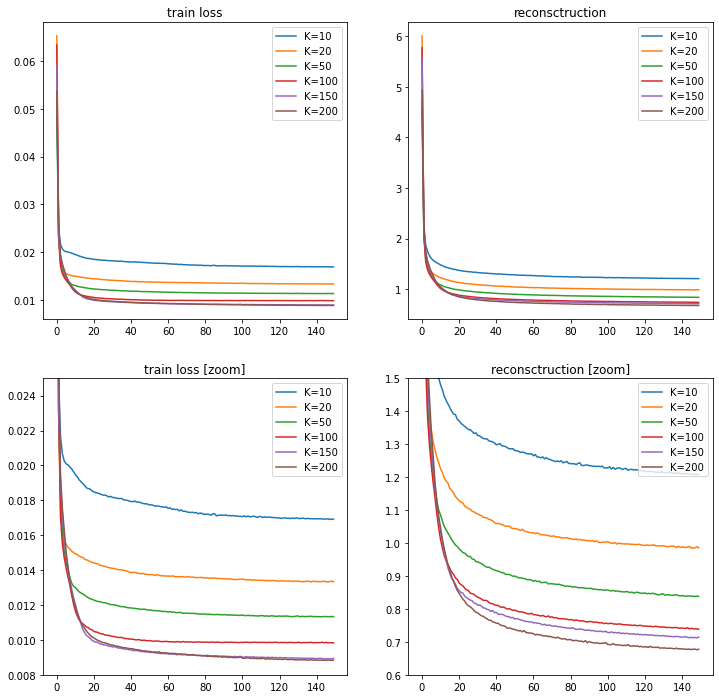

In [15]:
fig, ax = plt.subplots(ncols=2, nrows=2, figsize=(12,12))

ax[0,0].set_title("train loss")
ax[0,0].plot(ckpt_10["history_dict"]["train_loss"], label="K="+str(ckpt_10["num_embeddings"]))
ax[0,0].plot(ckpt_20["history_dict"]["train_loss"], label="K="+str(ckpt_20["num_embeddings"]))
ax[0,0].plot(ckpt_50["history_dict"]["train_loss"], label="K="+str(ckpt_50["num_embeddings"]))
ax[0,0].plot(ckpt_100["history_dict"]["train_loss"], label="K="+str(ckpt_100["num_embeddings"]))
ax[0,0].plot(ckpt_150["history_dict"]["train_loss"], label="K="+str(ckpt_150["num_embeddings"]))
ax[0,0].plot(ckpt_200["history_dict"]["train_loss"], label="K="+str(ckpt_200["num_embeddings"]))
ax[0,0].legend()

ax[0,1].set_title("reconsctruction")
ax[0,1].plot(ckpt_10["history_dict"]["train_rec"], label="K="+str(ckpt_10["num_embeddings"]))
ax[0,1].plot(ckpt_20["history_dict"]["train_rec"], label="K="+str(ckpt_20["num_embeddings"]))
ax[0,1].plot(ckpt_50["history_dict"]["train_rec"], label="K="+str(ckpt_50["num_embeddings"]))
ax[0,1].plot(ckpt_100["history_dict"]["train_rec"], label="K="+str(ckpt_100["num_embeddings"]))
ax[0,1].plot(ckpt_150["history_dict"]["train_rec"], label="K="+str(ckpt_150["num_embeddings"]))
ax[0,1].plot(ckpt_200["history_dict"]["train_rec"], label="K="+str(ckpt_200["num_embeddings"]))
ax[0,1].legend()

ax[1,0].set_title("train loss [zoom]")
ax[1,0].plot(ckpt_10["history_dict"]["train_loss"], label="K="+str(ckpt_10["num_embeddings"]))
ax[1,0].plot(ckpt_20["history_dict"]["train_loss"], label="K="+str(ckpt_20["num_embeddings"]))
ax[1,0].plot(ckpt_50["history_dict"]["train_loss"], label="K="+str(ckpt_50["num_embeddings"]))
ax[1,0].plot(ckpt_100["history_dict"]["train_loss"], label="K="+str(ckpt_100["num_embeddings"]))
ax[1,0].plot(ckpt_150["history_dict"]["train_loss"], label="K="+str(ckpt_150["num_embeddings"]))
ax[1,0].plot(ckpt_200["history_dict"]["train_loss"], label="K="+str(ckpt_200["num_embeddings"]))
ax[1,0].legend()
ax[1,0].set_ylim([0.008, 0.025])

ax[1,1].set_title("reconsctruction [zoom]")
ax[1,1].plot(ckpt_10["history_dict"]["train_rec"], label="K="+str(ckpt_10["num_embeddings"]))
ax[1,1].plot(ckpt_20["history_dict"]["train_rec"], label="K="+str(ckpt_20["num_embeddings"]))
ax[1,1].plot(ckpt_50["history_dict"]["train_rec"], label="K="+str(ckpt_50["num_embeddings"]))
ax[1,1].plot(ckpt_100["history_dict"]["train_rec"], label="K="+str(ckpt_100["num_embeddings"]))
ax[1,1].plot(ckpt_150["history_dict"]["train_rec"], label="K="+str(ckpt_150["num_embeddings"]))
ax[1,1].plot(ckpt_200["history_dict"]["train_rec"], label="K="+str(ckpt_200["num_embeddings"]))
ax[1,1].legend()
ax[1,1].set_ylim([0.6,1.5])         

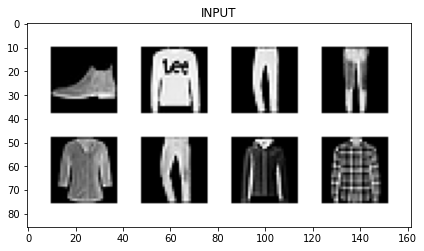

In [16]:
show_batch(ckpt_10["imgs_in"], title="INPUT")

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


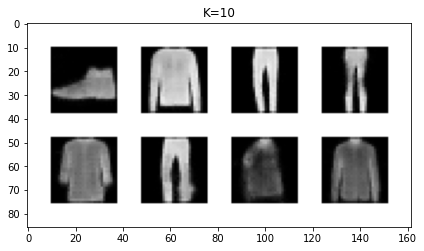

In [17]:
show_batch(ckpt_10["imgs_out"], title="K="+str(ckpt_10["num_embeddings"]))

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


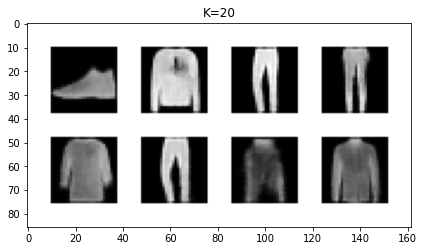

In [18]:
show_batch(ckpt_20["imgs_out"], title="K="+str(ckpt_20["num_embeddings"]))

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


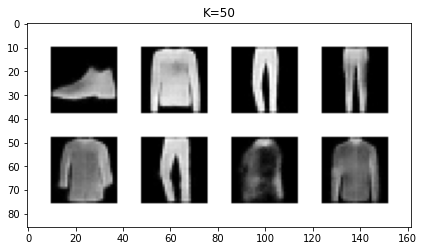

In [19]:
show_batch(ckpt_50["imgs_out"], title="K="+str(ckpt_50["num_embeddings"]))

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


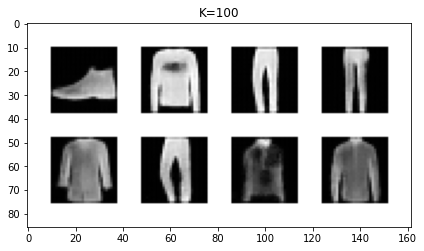

In [20]:
show_batch(ckpt_100["imgs_out"], title="K="+str(ckpt_100["num_embeddings"]))

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


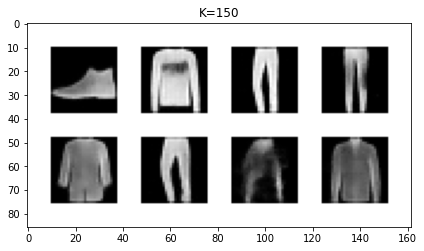

In [21]:
show_batch(ckpt_150["imgs_out"], title="K="+str(ckpt_150["num_embeddings"]))

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


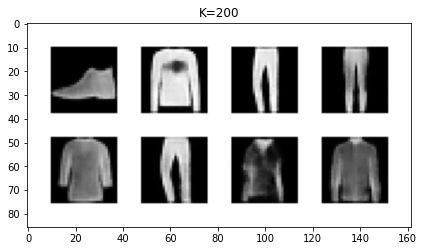

In [22]:
show_batch(ckpt_200["imgs_out"], title="K="+str(ckpt_200["num_embeddings"]))